In [ ]:
#@title Code: Run this cell to install  dependencies
## install libraries
from google.colab import auth as google_auth
google_auth.authenticate_user()

# !gsutil cp gs://vertex_sdk_llm_private_releases/SDK/google_cloud_aiplatform-1.23.0.llm.alpha.23.03.28-py2.py3-none-any.whl .
# !pip install google_cloud_aiplatform-1.23.0.llm.alpha.23.03.28-py2.py3-none-any.whl "shapely<2.0.0"
!pip install google-cloud-aiplatform --upgrade

!pip install google-cloud-core
!pip install youtube-transcript-api
!pip install tensorflow-text
!pip install nltk

**Restart runtime after the above installs**

In [ ]:
#@title Code: Run this cell to  import dependencies


## import
from youtube_transcript_api import YouTubeTranscriptApi
from google.cloud import aiplatform
from google.cloud.aiplatform.gapic.schema import predict
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import vertexai
from vertexai.language_models import TextGenerationModel, TextEmbeddingModel
# from google.cloud import aiplatform
# from google.cloud.aiplatform.private_preview.language_models import TextGenerationModel, ChatModel, TextEmbeddingModel

from IPython.display import HTML, display
#required for generating embeddings
import tensorflow_hub as hub
import numpy as np
import tensorflow_text
from numpy import dot
from numpy.linalg import norm
import numpy as np
import math
from IPython.display import YouTubeVideo

#for preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

vertexai.init(project="cloud-llm-preview2", location="us-central1")


def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)


def predict_large_language_model_sample(
    content: str,
    temperature: float,
    max_decode_steps: int,
    top_p: float,
    top_k: int,
    ):
  parameters = {
    "temperature": temperature,
    "max_output_tokens": max_decode_steps,
    "top_p": top_p,
    "top_k": top_k
  }
  model = TextGenerationModel.from_pretrained("text-bison@001")
  response = model.predict(content, **parameters)

  return response.text



def chunk_search_qna(text, question):
  chunk_size = 2500
  chunks = []
  for i in range(0, len(text), chunk_size-200):
    chunks.append(text[i:i + chunk_size])

  for chunk in chunks:
    res = predict_large_language_model_sample(f'''Respond in yes or no only.
      does the below text contain answer to the question:
      {question}\n TEXT: {chunk}''', 0.2, 256, 0.95, 40)

    if 'yes' in res.lower():
      prompt_question = f'''Based on all the text below and only on this text, give to-the-point answer this question "{question}".\n\n''' + chunk
      return predict_large_language_model_sample(prompt_question, 0.2, 256, 0.95, 40)

  return 'The text does not contain answer to this question'



def get_transcript(video_id):
  transcript = YouTubeTranscriptApi.get_transcript(video_id)
  merged_text = " ".join([t['text'] for t in transcript]).replace("\n", " ")

  return merged_text

def remove_stop_words(input_text:str) -> str:
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(input_text)

  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]

  return " ".join(filtered_sentence)

def get_embeddings_for_transcript(video_id):
  _transcript = YouTubeTranscriptApi.get_transcript(video_id)
  # print(len(_transcript))

  #load the embedding model from tensorflow hub
  # embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
  embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")


  _embedded_transcript = []

  line_count = 0
  line = ''
  line_start = 0
  line_processed = 0
  NUM_LINES = 4
  prev_line = ''

  #generate embeddings for the entire transcripts
  for t in _transcript:
    line_processed = line_processed + 1

    if line_count != NUM_LINES:
      line_count = line_count + 1 #increase the line count till it reaches NUM_LINES
      line = line + ' ' + t['text'] # append the lines

    if line_count == 1: #note the start for first line
      line_start = t['start']

    #on reaching NUM_LINES or the last line in the transcript, embed and add to the list
    if line_count == NUM_LINES or line_processed == len(_transcript):
      if line_processed != len(_transcript):
        line = line + ' ' + _transcript[line_processed]['text'] #creating overlaps

      if line_processed != 1:
        line = prev_line + ' ' + line  #creating overlaps, taking last 10 words from previous line

      line_unmodified = line
      line = remove_stop_words(line)

      # embedding = embed(line)[0].numpy()
      embedding = embedding_model.get_embeddings([line])[0].values

      _embedded_transcript.append({
      'text':line,
      'embedding':embedding,
      'start':line_start,
      'line_raw':line_unmodified
      })

      line_count = 0
      line = ''
      line_start = 0
      prev_line = t['text']
  # print(len(_embedded_transcript))
  return _embedded_transcript

def get_embedding(text):
  #load the embedding model from tensorflow hub
  # embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
  embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")
  text = remove_stop_words(text)
  # return embed(text)[0].numpy()
  return embedding_model.get_embeddings([text])[0].values

def get_answer_matching_transcript(merged_text, question):
  #get the exact answer from the text model with words matching the given transcript
  # prompt = f"""I want you to act as a student and you know only the context I give you and you answer
  # only from the context I have given you and you use mostly the words given in the context and answer my question.
  # The context is ({merged_text} and the question is {question})"""
  # prompt = f'''Answer the question in one word : {question}, based on the below context \n Context : {merged_text} \n ''' # sometimes hallucinations

  #the below prompt gave good results
  # prompt = f'''Answer  in (one sentence!) for the question : {question},
  # based on the below context \n Context : {merged_text} \n
  # '''

  prompt = f'''Answer the question in crisp and brief format: {question},
  based on the below context. You will use the words as it is mentioned in the context \n Context : {merged_text} \n'''
  # you use words only from the given dictionary \n dictionary : {merged_text.split(' ')}'''
  prompt = prompt[:20000]

  return predict_large_language_model_sample(prompt, temperature, max_decode_steps, top_p, top_k)

def get_summary(video_id):
  merged_text = get_transcript(video_id)
  summarize_prompt = "Summarize all the text below in few sentences.\n" #worked perfectly
  #summarize_prompt = "Summaraize \n" # does not cover the full text. Some portions were ommitted
  #summarize_prompt = "Summaraize all the text below\n" #too much of hallucinations

  prompt_summary = summarize_prompt + merged_text
  return predict_large_language_model_sample(prompt_summary, temperature, max_decode_steps, top_p, top_k)


def get_answer(video_id, question):
  merged_text = get_transcript(video_id)
  prompt_question = f'''Answer the question : {question}, based on the below context \n Context : {merged_text} \n ''' # correct

  return predict_large_language_model_sample(prompt_question, temperature, max_decode_steps, top_p, top_k)



def jumpto_timestamps(video_id, question):
  print(f'Question : {question}')

  #get exact matching answere from text model
  ans_qna = get_answer_matching_transcript(get_transcript(video_id), question)

  print(f'Answer : {ans_qna}')
  print("**************************************************************")
  print("The following relevant details are found in the youtube video:")
  print("**************************************************************")
  #embed the entire transcript line by line with start time
  embedded_transcript = get_embeddings_for_transcript(video_id)

  #embed the answer given by the model
  ans_qna_embeddings = get_embedding(ans_qna)

  answers_in_video = []
  from scipy.spatial import distance

  #calculate cosine similarity
  for e in embedded_transcript:
    # cos_sim = dot(e['embedding'], ans_qna_embeddings)/(norm(e['embedding'])*norm(ans_qna_embeddings))
    cos_sim = 1 - distance.cosine(e['embedding'], ans_qna_embeddings)
    e["similarity"] = cos_sim
    answers_in_video.append(e)
    # if cos_sim > 0.4:
    #   answers_in_video.append(e)

  #sort the list based on cosine similarity
  most_matching_answers = sorted(answers_in_video, key=lambda d: d['similarity'], reverse=True)

  #present the result to the user
  for ans in most_matching_answers[:4]: #presenting only the first two results
    start = ans['start']
    print(f'\nTranscript : {ans["line_raw"]}')
    print(f"Kewords: {ans['text']} \n [MATCH : {round(ans['similarity'] * 100, 1) }%]")
    display(YouTubeVideo( id=video_id, width=700, height=300, allow_autoplay=False, start=math.ceil(float(start))))


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
nltk.download('punkt')

a = get_embedding('6 %')
b = get_embedding('6 percent')
cosine_similarity([a], [b])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


array([[0.96923938]])

In [ ]:
#@title You can keep this parameters as default or experiment with the values

temperature = 0.2 # @param {type:"number"}
max_decode_steps = 1024 # @param {type:"number"}
top_p = 0.95 # @param {type:"number"}
top_k = 40 # @param {type:"number"}

#Use Case : Stock Market

In [ ]:
#@title Enter the Youtube URL here
#youtube_video_url = "https://www.youtube.com/watch?v=R8tBERK92kk&t=2s"# @param {type:"string"}

youtube_video_url = "https://www.youtube.com/watch?v=FtLWDjNMPgs"# @param {type:"string"}

video_id = youtube_video_url.split('?v=')[-1]

In [ ]:
#@title Run this to get summary

print(get_summary(video_id))

The video introduces Lang chain, a framework for developing applications powered by large language models. It explains the components of Lang chain and the three types of models that are supported: text, chat, and embeddings. The video then provides an overview of the use cases that Lang chain can be used for, including reading a PDF and adding Q&A, creating a summarization task of a website, and searching on a website.


Question : How many models are supported from Model Garden in LangChain?
Answer : LangChain supports three models from Model Garden: text, chat, and embeddings.
**************************************************************
The following relevant details are found in the youtube video:
**************************************************************

Transcript : vertex AI this is where the Lang chain  uses vertex aim bearings vertex AI so langchin has chat models embeddings and llm remember this slide llms chat and embedding these are the three models
Kewords: vertex AI Lang chain uses vertex aim bearings vertex AI langchin chat models embeddings llm remember slide llms chat embedding three models 
 [MATCH : 82.8%]


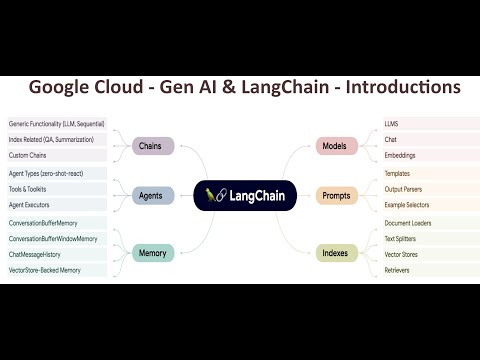


Transcript : only these three models are supported in  Lang chain as of now and this space is changing super fast so text bison at the rate001 we're gonna see example of this chat python we are also look at an example of this and text
Kewords: three models supported Lang chain space changing super fast text bison rate001 're gon na see example chat python also look example text 
 [MATCH : 82.3%]


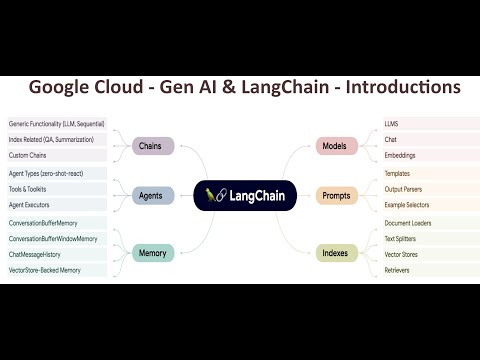


Transcript : so going forward if I use embeddings  that means I'm using the vertex here I am wearing the chat and the llm run it next now let's look at the three primitive models llms chat and text
Kewords: going forward use embeddings means 'm using vertex wearing chat llm run next let 's look three primitive models llms chat text 
 [MATCH : 80.5%]


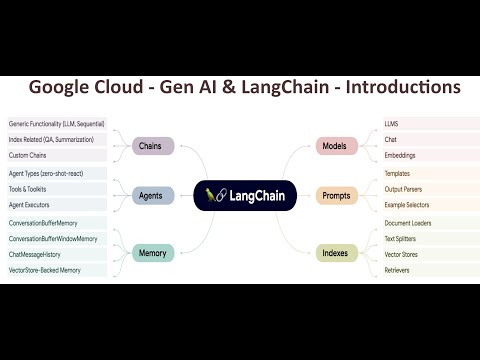


Transcript : next now let's look at the three  primitive models llms chat and text embeddings now llm remember this is the vertex AI text bison I'm going to ask which is the parent
Kewords: next let 's look three primitive models llms chat text embeddings llm remember vertex AI text bison 'm going ask parent 
 [MATCH : 78.8%]


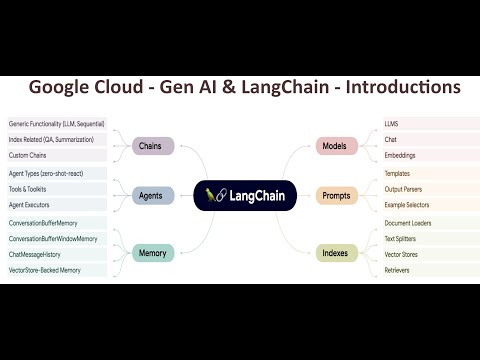

In [ ]:
#@title Run this to locate the answer in video
question = "How many models are supported from Model Garden in LangChain?"# @param {type:"string"}

jumpto_timestamps(video_id, question)

In [ ]:
#@title Run this to get answer to this question
question = "How much does apple share price jump?"# @param {type:"string"}
question = "How many models are supported from Model Garden in LangChain?"# @param {type:"string"}

print(get_answer(video_id, question))

3 models are supported from Model Garden in LangChain. These are text bison, chat, and text embeddings.


Question : How many models are supported from Model Garden in LangChain?
Answer : Only three models are supported in LangChain as of now. These are text bison, chat, and text embeddings.
**************************************************************
The following relevant details are found in the youtube video:
**************************************************************

Transcript : only these three models are supported in  Lang chain as of now and this space is changing super fast so text bison at the rate001 we're gonna see example of this chat python we are also look at an example of this and text
Kewords: three models supported Lang chain space changing super fast text bison rate001 're gon na see example chat python also look example text 
 [MATCH : 87.3%]


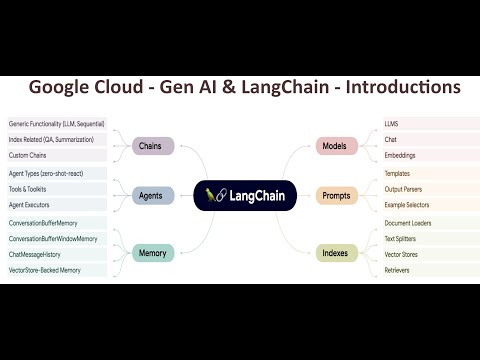


Transcript : next now let's look at the three  primitive models llms chat and text embeddings now llm remember this is the vertex AI text bison I'm going to ask which is the parent
Kewords: next let 's look three primitive models llms chat text embeddings llm remember vertex AI text bison 'm going ask parent 
 [MATCH : 80.9%]


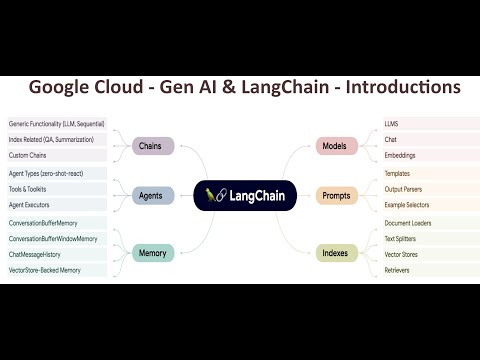


Transcript : vertex AI this is where the Lang chain  uses vertex aim bearings vertex AI so langchin has chat models embeddings and llm remember this slide llms chat and embedding these are the three models
Kewords: vertex AI Lang chain uses vertex aim bearings vertex AI langchin chat models embeddings llm remember slide llms chat embedding three models 
 [MATCH : 79.5%]


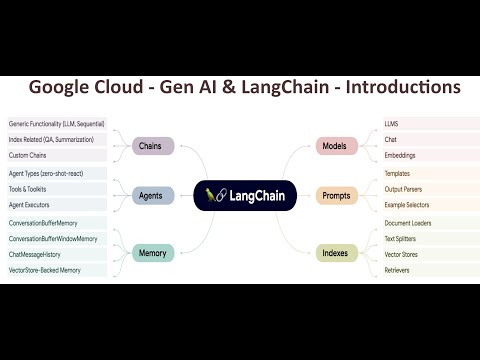


Transcript : so going forward if I use embeddings  that means I'm using the vertex here I am wearing the chat and the llm run it next now let's look at the three primitive models llms chat and text
Kewords: going forward use embeddings means 'm using vertex wearing chat llm run next let 's look three primitive models llms chat text 
 [MATCH : 78.0%]


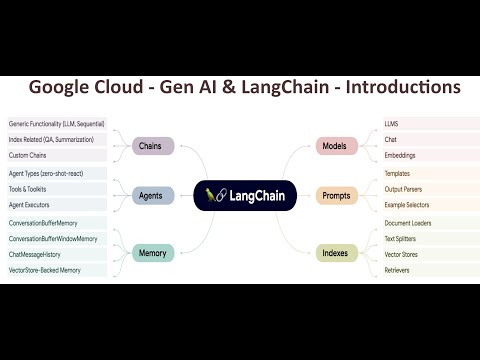

In [ ]:
#@title Run this to locate the answer in video
jumpto_timestamps(video_id, question)

In [ ]:
#@title Run this to get answer to this question
question = "What is a Prompt Template in Langchain?"# @param {type:"string"}
print(get_answer(video_id, question))


A prompt template is a string that is used to create a prompt for a large language model. The prompt template can include variables that are replaced with user input. For example, a prompt template for a travel chatbot might be "I want to travel to a location. What should I do there?". The variable "location" would be replaced with the user's desired destination.


Question : What is a Prompt Template in Langchain?
Answer : A prompt template is a string that is used to create a prompt for a large language model. The prompt template can include variables that are replaced with user input. For example, the prompt template "I want to travel to a location. What should I do there?" could be used to create a prompt for a travel chatbot. The user would then be asked to provide a location, and the chatbot would generate a response based on that location.
**************************************************************
The following relevant details are found in the youtube video:
**************************************************************

Transcript : I'm gonna create a template it's just a  string I say I want to really travel to a location what should I do there so what you're going to ask the user is the location please note that the location is in the curly braces
Kewords: 'm gon na create template 's string say want really travel location 're goin

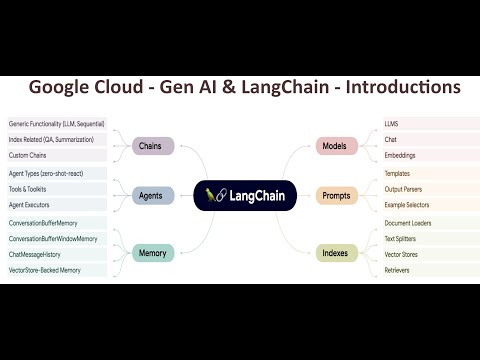


Transcript : variable input variable location which  is here and template use this template so you created a prompt which is in an instance of prompt template from template is nothing but a package or a
Kewords: variable input variable location template use template created prompt instance prompt template template nothing package 
 [MATCH : 81.3%]


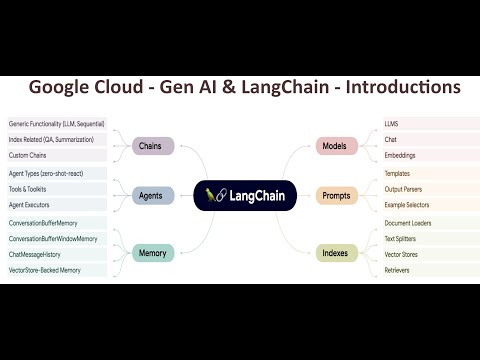


Transcript : let's look at example below  so I'm going to create a prompt using prompt template now let's look at it I'm gonna create a template it's just a string I say I want to really travel to
Kewords: let 's look example 'm going create prompt using prompt template let 's look 'm gon na create template 's string say want really travel 
 [MATCH : 79.9%]


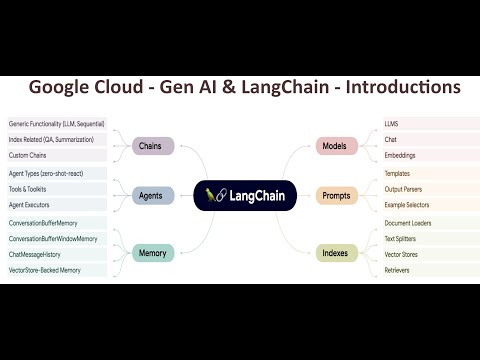


Transcript : short tendon  here I'm going to create a prompt template I'm deciding that there is only one variable input variable location which is here
Kewords: short tendon 'm going create prompt template 'm deciding one variable input variable location 
 [MATCH : 79.6%]


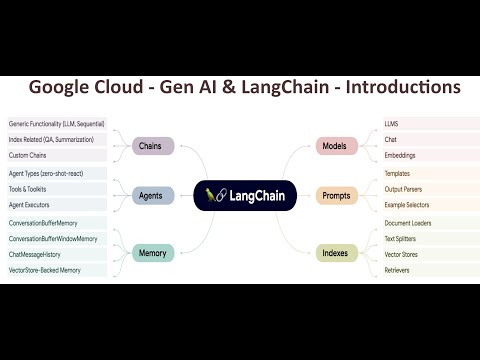

In [ ]:
#@title Run this to locate the answer in video
jumpto_timestamps(video_id, question)

In [ ]:
#@title Enter the Youtube URL here

youtube_video_url = "https://www.youtube.com/watch?v=Do3mfeR1isg"# @param {type:"string"}

video_id = youtube_video_url.split('?v=')[-1]

In [ ]:
#@title Run this to get summary

print(get_summary(video_id))

stairs it can even run it's a The speaker is a professor at the mechanical aerospace engineering department and the director of the robotics and mechanism laboratory at UCLA. He is showing us some of the robots they have developed. The robots are very impressive. They can walk, climb stairs, and even run. The speaker is also talking about the challenges of developing robots and how they are trying to overcome them.


#Use Case : Product Review (iPhone - 14 minutes)

In [ ]:
#@title Enter the Youtube URL here

youtube_video_url = "https://www.youtube.com/watch?v=v94jRN2FhGo"# @param {type:"string"}

video_id = youtube_video_url.split('?v=')[-1]

In [ ]:
#@title Run this to get summary

print(get_summary(video_id))

The iPhone 14 is a minor upgrade from the iPhone 13. It has the same design, chip, and display as the previous model. However, it does have some new features, such as a slightly improved camera, satellite connectivity, and crash detection.

Overall, the iPhone 14 is a good phone, but it is not a major upgrade from the iPhone 13. If you are looking for a new iPhone, you may want to consider the iPhone 14 Pro or Pro Max, which have more significant upgrades.


In [ ]:
#@title Run this to get answer to this question
question = "what is the price of iphone 14 ?"# @param {type:"string"}
print(get_answer(video_id, question))

6.99


In [ ]:
merged_text = get_transcript(video_id)
chunk_search_qna(merged_text, question)

'The text does not contain anmswer to this question'

Question : what is the price of iphone 14 ?
Answer : The price of the iPhone 14 is $699.
**************************************************************
The following relevant details are found in the youtube video:
**************************************************************

Transcript : products so this year we do get an  iphone 14 and an iphone 14 plus this 14 is out now and the 14 plus is coming out in a month in october it's basically the same thing just bigger 6.1 inches here 6.7 inches there and so many things are
Kewords: products year get iphone 14 iphone 14 plus 14 14 plus coming month october 's basically thing bigger 6.1 inches 6.7 inches many things 
 [MATCH : 77.7%]


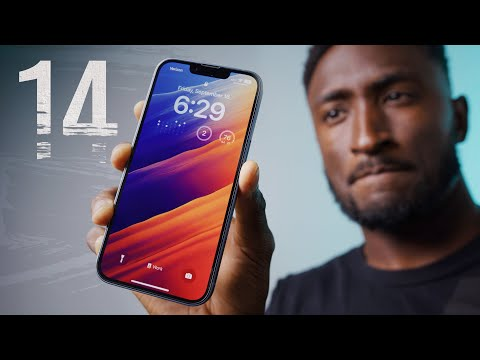


Transcript : get but one last wrench to throw into  all of this is that the iphone 13 is still on sale and it's 6.99 from apple but you can probably find it even cheaper from other places
Kewords: get one last wrench throw iphone 13 still sale 's 6.99 apple probably find even cheaper places 
 [MATCH : 76.6%]


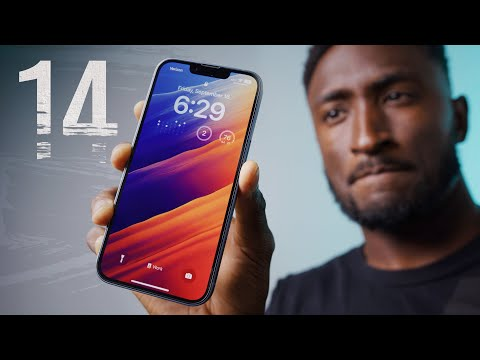


Transcript : same thing just bigger 6.1 inches here  6.7 inches there and so many things are the same as last year's phone on the outside the design is the same the iphone 13 cases literally work with the iphone 14. like this is the new ali
Kewords: thing bigger 6.1 inches 6.7 inches many things last year 's phone outside design iphone 13 cases literally work iphone 14. like new ali 
 [MATCH : 75.1%]


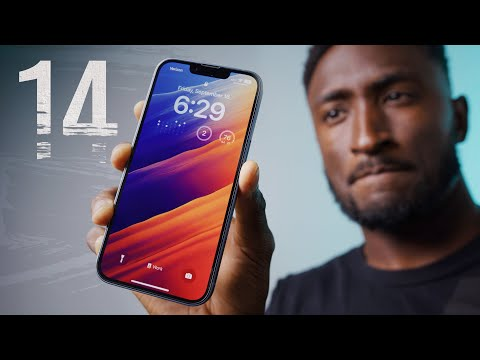


Transcript : even more expensive phones you know you  watch that iphone 14 pro review and you see the dynamic island which is a thing that's new to the iphone it'll evolve over time you see the new 48 megapixel camera system which is new to the iphone
Kewords: even expensive phones know watch iphone 14 pro review see dynamic island thing 's new iphone 'll evolve time see new 48 megapixel camera system new iphone 
 [MATCH : 73.8%]


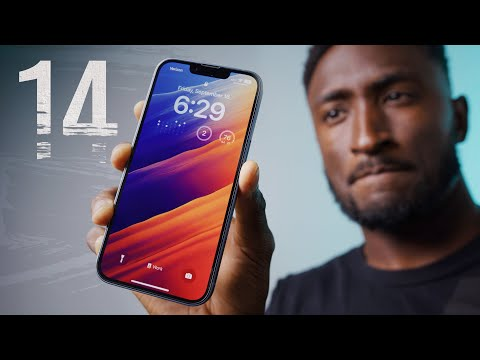

In [ ]:
#@title Run this to locate the answer in video
jumpto_timestamps(video_id, question)

In [ ]:
#@title Run this to get answer to this question
question = "what is the specifications of iphone 14 for the base model? List point by point"# @param {type:"string"}
print(get_answer(video_id, question))

1. A15 Bionic chip
2. 6.1-inch display
3. 60Hz refresh rate
4. 4GB of RAM
5. 128GB, 256GB, or 512GB of storage
6. Dual-lens rear camera system (12MP wide and 12MP ultrawide)
7. 12MP front-facing camera
8. Face ID
9. Lightning port
10. iOS 16
